In [ ]:
'''
Objective:
----------
To use template matching with thresholding to identify regions within the svs image that may have a certain 
type of cell. The template is chosen based on some defining visual feature of the cell type. This
form of automatic identification of 'regions of interest' can drastically reduce the time required by a trained
pathologist to manually annotate specific cell types. This method can be used as a bootstrapping method to speed
up the annotation process for building supervised learning models. The supervised learning models can then be used 
to increase the annotated content in a similar manner, and consequently for improving the models themselves in an 
iterative manner. 

Experiment:
-----------
- This is an attempt to use opencv template matching with thresholding to identify mk-cells in 800x800 tiff regions 
of interest. 
- The intuition here is to take the large cytoplasmic area of the mk-cells as a defining visual feature and 
make a template out of it.
- Thresholding is used to identify two or more such areas in the tile that may point to possible mk-cells.
- In this experiment, all regions of interest are taken from the same svs image as the template because each svs may
have a different hue and contrast that may be dependent on the staining for that sample. But, further experimentation
can be conducted to see if this technique works for tiles across two or more svs files.
- Tile used in this experiment are named after the svs file they were extracted from and the top left coordinates
within that svs file - <svs file name>-x-cood-y-cood.tiff. 
- Use environment.yml to set up dependencies with conda for this notebook. 
    $ conda env create -f environment.yml 

Observations:
-------------
- Even though the template for the cytoplasm is just a few pixels, template matching still works on exact copy. The 
exact copy match works best with TM_CCOEFF_NORMED algorithm. This algorithm seems to either find an exact copy match 
or it finds nothing. 
- Of the following algorithms, [TM_CCOEFF, TM_CCOEFF_NORMED, TM_CCORR, TM_CCORR_NORMED, TM_SQDIFF, TM_SQDIFF_NORMED]
TM_SQDIFF works best in identifying regions with large cytoplasmic content which could be indicative of the presence 
of mk-cells. Regions with tissue containing cells with no nuclii (possible red blood cells) also get identified by 
TM_SQDIFF, but these regions are easy enough to discern and ignore. 
- TM_CCORR and TM_CCORR_NORMED perform terribly and this may possibly be a result of an improper setup for these two 
algorithms. This needs to be verified. 
- varying the threshold in the range [0.8-0.95] increases or descreases the number of regions of interest. 

Inference:
----------
- Template matching is possibly the most primitive form of object detection and the results here look quite promising
to continue exploring further to refinne this method of identifying regions of interest for specific types of cells

- ideas to try are 

1. template matching on tiles from two or more svs files to see how this method performs with varying hues and 
contrasts from staining
2. experiment with some other defining visual feature of a certain cell type to see if similar results can be obtained
3. boost contrast with histogram equalization and then applying template matching to see if this method affords 
better coverage (minimize regions that contain the cell(s) of interest but remain unidentified)
'''

In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# summary description
def describe(img, title='plot'):
    print('shape: '+str(img.shape))  
    print('type: '+str(type(img)))

    fig = plt.figure(figsize=(20,20))  # 20x20 magnification
    ax = fig.add_subplot(1,1,1)
    plt.title(title)
    ax.imshow(img)
    
# data normalization (bring values in range [0,1])
def normalizeData(data):
    return (data - np.min(data)) / (np.max(data) - np.min(data))

shape: (800, 800, 3)
type: <class 'numpy.ndarray'>


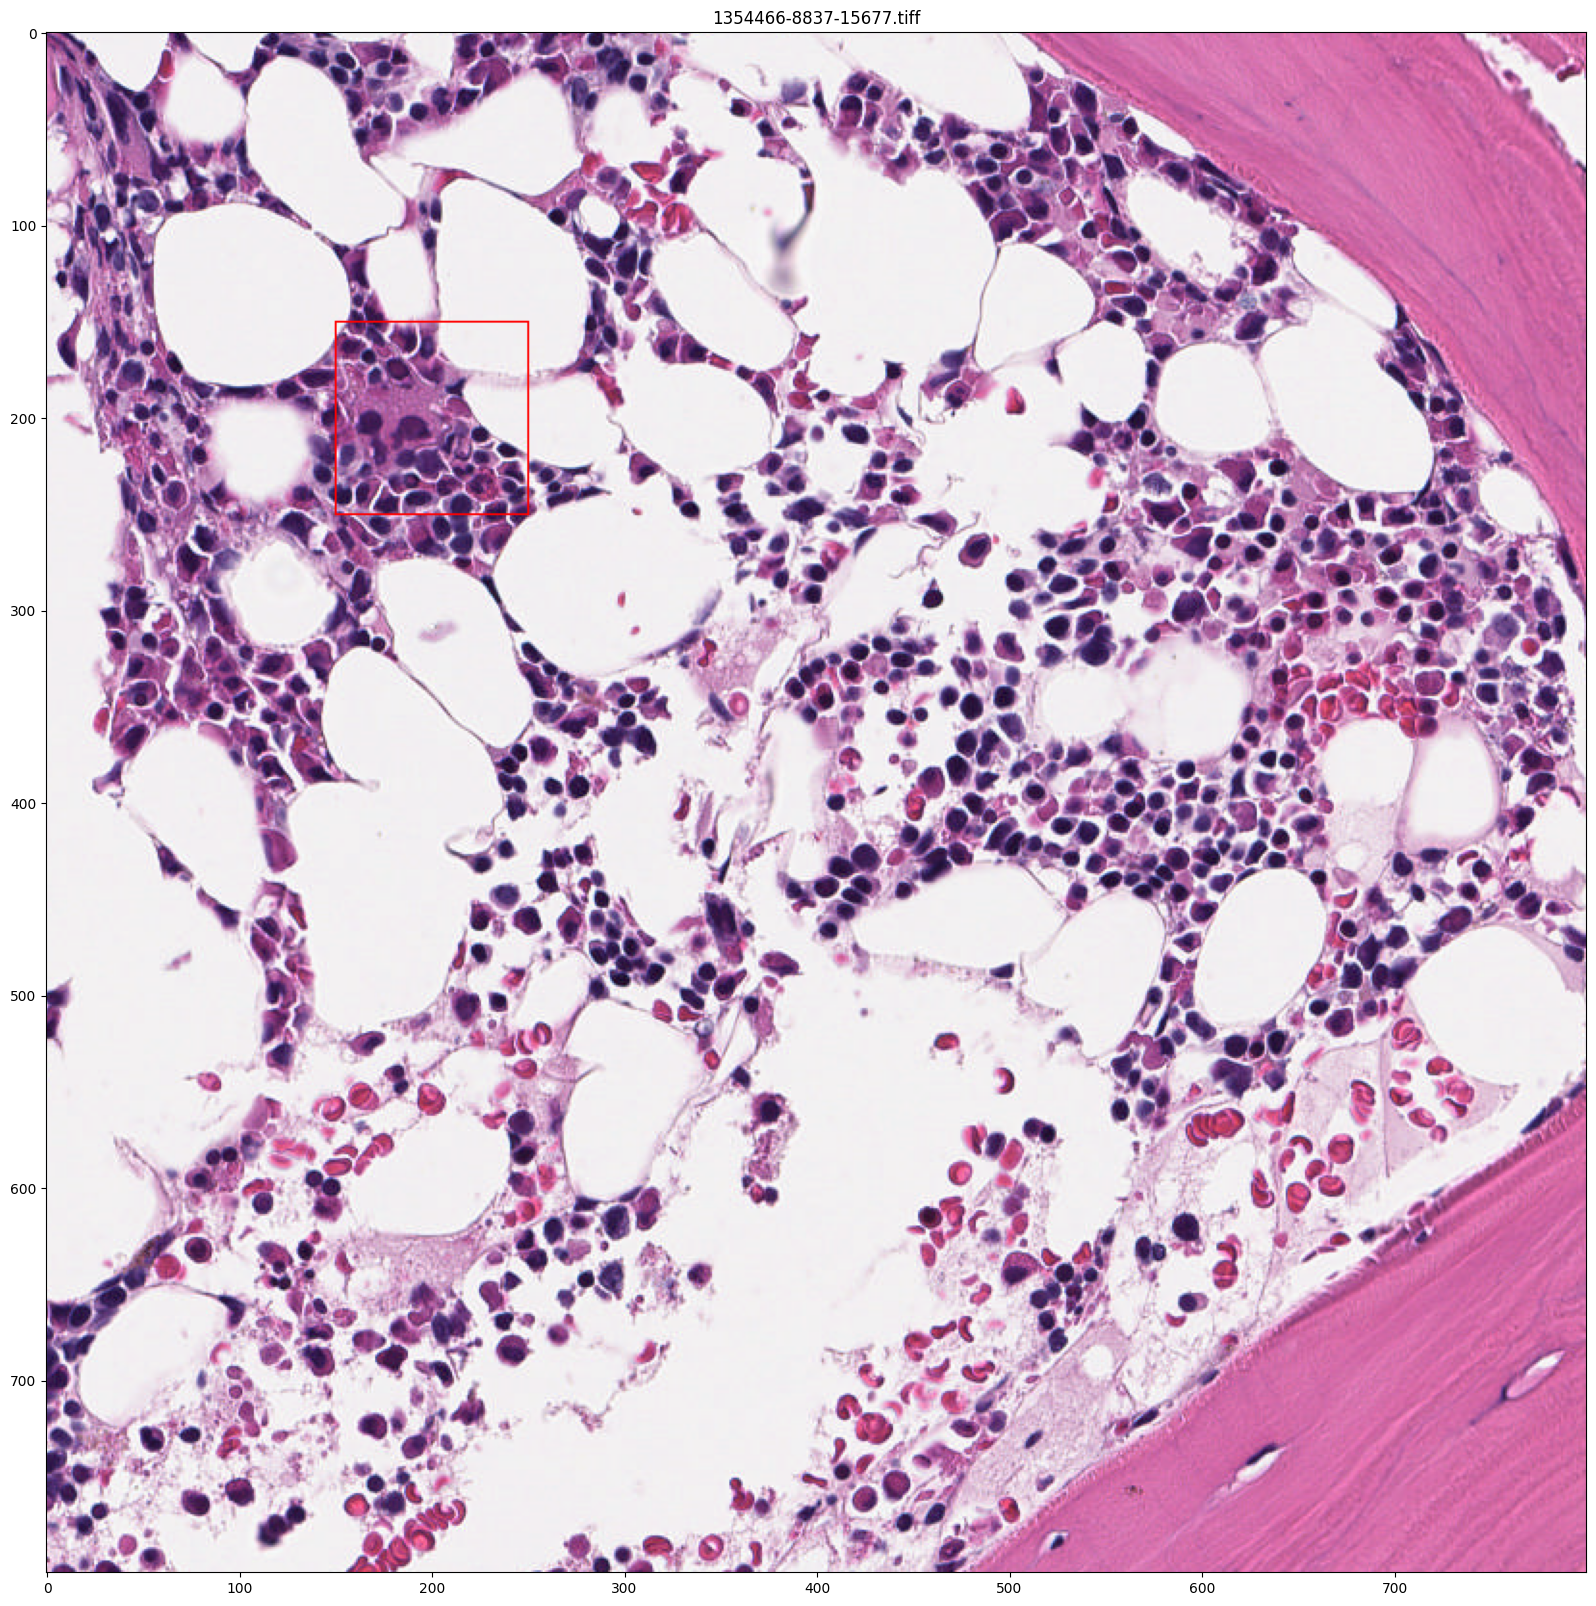

In [3]:
img = cv2.imread("1354466-8837-15677.tiff")
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img_cpy = img.copy()
cv2.rectangle(img, (150,150), (250,250), color=255, thickness=1)
describe(img, title='1354466-8837-15677.tiff')
img = img_cpy

In [10]:
y1 = -150 + 200
y2 = -150 + 250
x1 = -150 + 200
x2 = -150 + 250

shape: (100, 100, 3)
type: <class 'numpy.ndarray'>


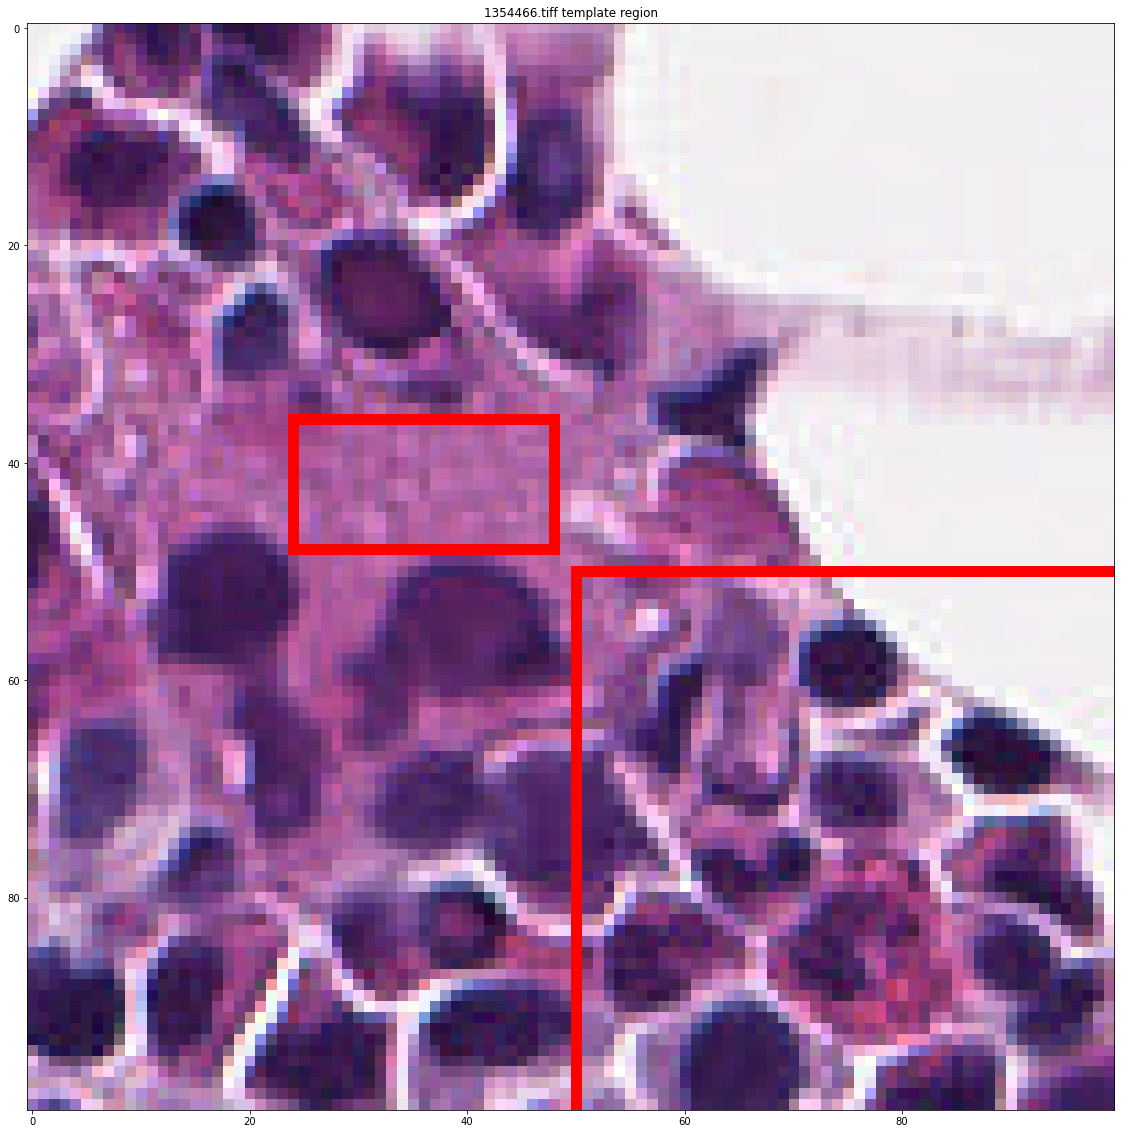

In [14]:
img_template_region = img[150:250, 150:250, 0:3]
img_template_region_cpy = img_template_region.copy()
cv2.rectangle(img_template_region, (y1,x1), (y2,x2), color=255, thickness=1)
describe(img_template_region, title='1354466.tiff template region')
img_template_region = img_template_region_cpy

shape: (50, 50, 3)
type: <class 'numpy.ndarray'>


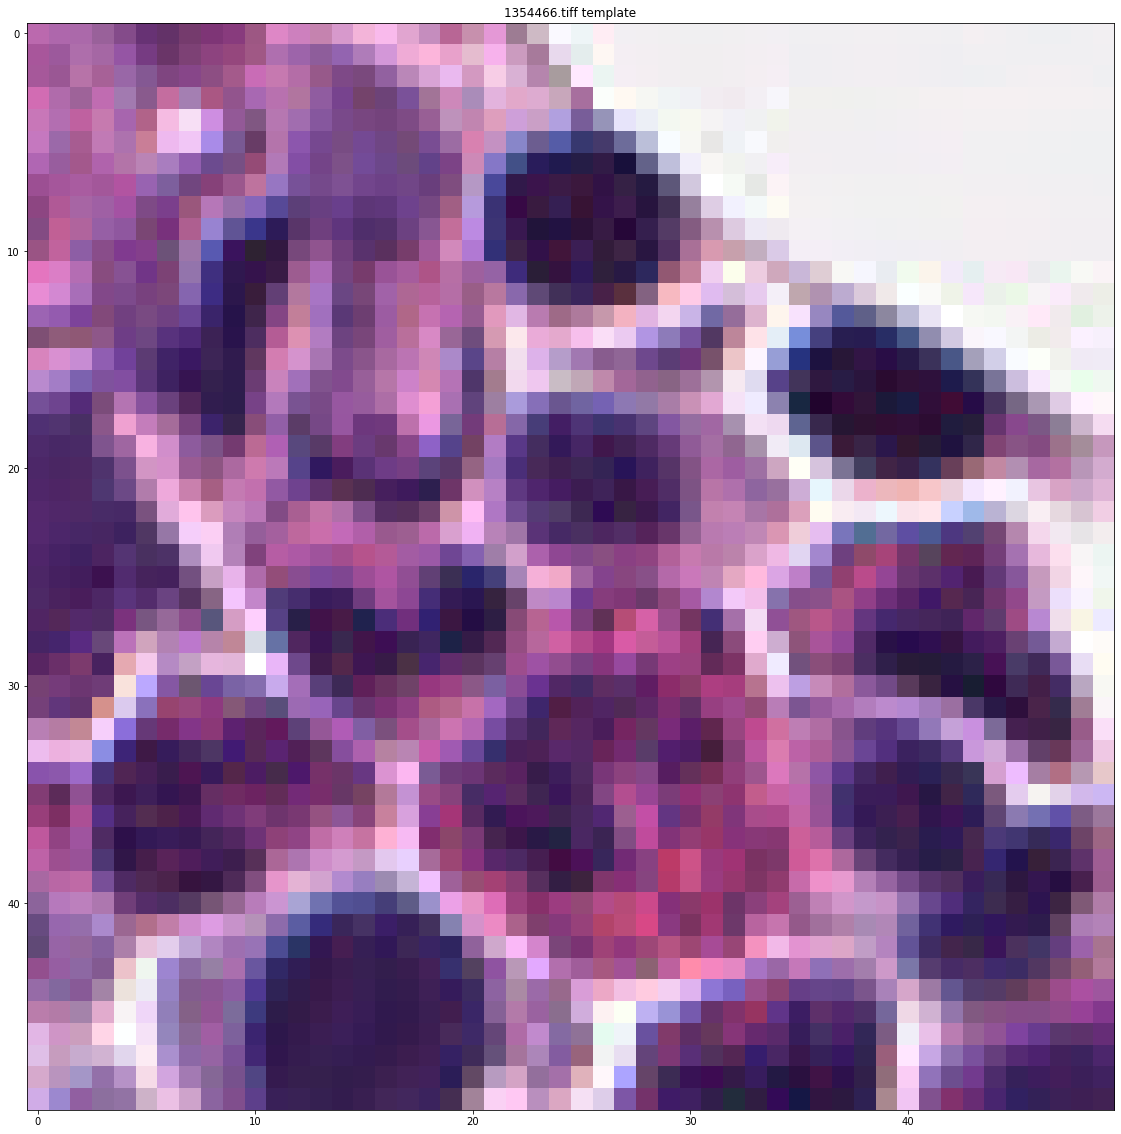

In [11]:
img_template = img_template_region[y1:y2,x1:x2, 0:3] # y_range, x_range, color_range
describe(img_template, title='1354466.tiff template')

In [6]:
# All the 6 methods for comparison in a list
# Note how we are using strings, later on we'll use the eval() function to convert to function
methods = [
    'cv2.TM_CCOEFF', 
    'cv2.TM_CCOEFF_NORMED', 
    'cv2.TM_CCORR',
    'cv2.TM_CCORR_NORMED', 
    'cv2.TM_SQDIFF', 
    'cv2.TM_SQDIFF_NORMED'
]

In [ ]:
# try template matching on different tiles 

# uncomment one tile name at a time
#tile_name="1354466-8837-15677.tiff"  # template is taken from this tile
#tile_name="1354466-7900-15800.tiff"
#tile_name="1354466-34000-5500.tiff" 
#tile_name="1354466-33500-4000.tiff" 
#tile_name="1354466-33000-7500.tiff" 
tile_name="1354466-32800-7300.tiff"  

img = cv2.imread(tile_name)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
describe(img, title=tile_name)

In [ ]:
height, width,channels = img_template.shape

for m in methods:
    
    # Create a copy of the image
    full_copy = img.copy()
    
    # Get the actual function instead of the string
    method = eval(m)

    # Apply template Matching with the method
    res = cv2.matchTemplate(full_copy,img_template,method)
    
    if method in [cv2.TM_CCOEFF, cv2.TM_CCORR, cv2.TM_SQDIFF]:
        res = normalizeData(res)
    
    # set a threshold
    threshold = 0.9
    
    # If the method is TM_SQDIFF or TM_SQDIFF_NORMED, take minimum
    if method in [cv2.TM_SQDIFF, cv2.TM_SQDIFF_NORMED]:
        loc = np.where( res <= 1-threshold)
    else:
        loc = np.where( res >= threshold)
    
    # Draw the Red Rectangle
    for pt in zip(*loc[::-1]):
        cv2.rectangle(full_copy, pt, (pt[0] + width, pt[1] + height), color=255, thickness=1)
        
    describe(full_copy, title=m)